# The Jarvis Code senteinal tuturial 2 

Content 内容
* Time series download 時系列のダウンロード 
* Multi band Tiff data　複数のバンドのTiffのデータを扱い
* NDVI 　



# Imports 

In [ ]:
!pip3 install sentinelhub

In [ ]:
%matplotlib inline
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os 
from sentinelhub import MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, \
    DataCollection, bbox_to_dimensions, DownloadRequest

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

!pip3 install python-dotenv
from dotenv import load_dotenv
import os 
load_dotenv("/content/drive/MyDrive/Accounts/sentinalhub.env")

from sentinelhub import SHConfig
config = SHConfig()
config.sh_client_id=os.environ["ID"]  #input("OAuth ID ") #"{OAuth ID }
config.sh_client_secret=os.environ["Secret"]#= #input("OAuth secret key") #"{OAuth secret key}"
if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

Target Area [Geojson ](http://geojson.io/#map=10/42.6542/140.7513) 　nakajima Hokkaidou 中島（なかじま）・北海道

In [ ]:
target_coords = [  140.7582,
          42.5540,
          140.9573,
          42.6904
          
        ] #WGS84
res=10
target_bbox= BBox(bbox=target_coords,crs=CRS.WGS84)
target_size= bbox_to_dimensions(target_bbox,resolution=res)

print(f'Image shape at {res} m resolution: {target_size} pixels')

Image shape at 10 m resolution: (1635, 1512) pixels


# Sentianl hub request function 

In [ ]:
evalscript_true_color="""
 //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""
evalscript_all_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"],
                units: "DN"
            }],
            output: {
                bands: 13,
                sampleType: "INT16"
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B01,
                sample.B02,
                sample.B03,
                sample.B04,
                sample.B05,
                sample.B06,
                sample.B07,
                sample.B08,
                sample.B8A,
                sample.B09,
                sample.B10,
                sample.B11,
                sample.B12];
    }
"""

In [ ]:
DataCollection.SENTINEL2_L1C

In [ ]:
def get_true_color_request(time_interval,my_bbox,my_size,config=config):
    return SentinelHubRequest(
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=time_interval,
                mosaicking_order='leastCC'
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.PNG)
        ],
        bbox=my_bbox,
        size=my_size,
        config=config
    )


def getband_request(time_interval,my_bbox,my_size,evalscript=evalscript_all_bands,config=config):
    return SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=time_interval,
                mosaicking_order='leastCC'
            )
        ],
         responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
        bbox=my_bbox,
        size=my_size,
        config=config
    )

In [ ]:

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=('2020-06-1', '2020-06-20'),
             mosaicking_order='leastCC' # Least cloud cover 雲量がすくない画像
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=target_bbox,
    size=target_size,
    config=config
)
test_img=request_true_color.get_data()

In [ ]:
def hist_color_img(img,ax=None,range=None):
  if not ax:
    fig,ax=plt.subplots(1,1,figsize=(8,6))

  _= ax.hist(img[:,:,0].reshape(-1),bins=20,label="blue",color="blue",alpha=0.8,range=range)
  _= ax.hist(img[:,:,1].reshape(-1),bins=20,label="green",color="green",alpha=0.8,range=range)
  _= ax.hist(img[:,:,2].reshape(-1),bins=20,label="red",color="red",alpha=0.8,range=range)
  ax.legend()
  ax.grid()


def plt_img_hist(img):
  fig,axs= plt.subplots(1,2,figsize=(10,6))
  axs[0].imshow(img)
  axs[0].axis(False)
  hist_color_img(img,axs[1])

plt_img_hist(test_img[0]*3.5/255)

In [ ]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

start = datetime(2020,1,1)
M=12
slots=[]
for m in range(0,M):
  end=start+ relativedelta(months=1,days=-1) #Get end of month
  slots.append((start.date().isoformat(),end.date().isoformat())) #('2020-02-01', '2020-02-29') save as string \
  start=end+ relativedelta(days=1)  #Change to next month 


"""
end = datetime.datetime(2020,12,31)
years=1
n_chunks=13*years#+1
tdelta = (end - start) / n_chunks
edges = [(start + i*tdelta).date().isoformat() for i in range(n_chunks)]
slots = [(edges[i], edges[i+1]) for i in range(len(edges)-1)]
"""

print('Monthly time windows:\n')
for slot in slots:
    print(slot)

In [ ]:
# create a list of requests
list_of_requests = [get_true_color_request(slot,target_bbox,target_size) for slot in slots]
list_of_requests = [request.download_list[0] for request in list_of_requests]
# download data with multiple threads
images = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=5)

In [ ]:
images=np.array(images)
print(images.shape)

1

In [ ]:

def Sat_timeplot(images,my_size,slots,factor=1,ncols=3,bandlist=None):
    #多い画像数があると、サイズが調整しにくくなる。枚量を対応するために「aspect_ratio」というサイズの割合を使用します。
    aspect_ratio = my_size[1] / my_size[2]
    print(aspect_ratio)
    L=len(images)
    #列の数から行の数を設定
    nrows=L//ncols 
    if nrows % 2==1:
      nrows+=1
      #Figureを作成して、ncols,nrowsの部分の分かる
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols * aspect_ratio, 5 * nrows))
    print(np.shape(axs))
      #それぞれの画像をロープして、プロットします               
    for idx in range(0,L):
        ax = axs[idx // ncols][idx % ncols] #plot in rows and cols 
        if bandlist: #Multio band option  #色のバンドの順番を変更する機能
          ax.imshow(images[idx][:,:,bandlist]*factor)
        else: 
          ax.imshow(images[idx] * factor)
        ax.axis(False)
          #日付を題名のように表示する
        ax.set_title(f'{slots[idx][0]}  -  {slots[idx][1]}', fontsize=10)
    plt.tight_layout()


In [ ]:
Sat_timeplot(images,images.shape,slots,factor=3.5/255)

In [ ]:

list_of_requests = [getband_request(slot,target_bbox,target_size) for slot in slots]
list_of_requests = [request.download_list[0] for request in list_of_requests]
# download data with multiple threads
band_images = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=5)
band_images= np.array(band_images)

In [ ]:


def hist_band_img(img,bands,band_names,ax=None,range=None):
  if not ax:
    fig,ax=plt.subplots(1,1,figsize=(8,6))
  for band,name in zip(bands,band_names): 
    _= ax.hist(img[:,:,band].reshape(-1),bins=20,label=name,alpha=0.8,range=range)
  ax.legend()
  ax.grid()


def plt_band_img_hist(img,bands,band_names):
  fig,axs= plt.subplots(1,2,figsize=(10,6))
  axs[0].imshow(img[:,:,bands])
  axs[0].axis(False)
  hist_band_img(img,bands,band_names,axs[1])


In [ ]:
band_images.shape
BANDS=['B01', 'B02', 'B03', 'B04', 'B05',
       'B06', 'B07', 'B08', 'B8A', 'B09', 
       'B10', 'B11', 'B12']
band_names=["B12","B08","B04"]
bands=[12,7,3]
plt_band_img_hist(band_images[3]*3.5/1e04,bands,band_names)

In [ ]:
Sat_timeplot(band_images,band_images.shape,slots,factor=3.5/1e04,bandlist=[12,7,3])

# NVDI

In [ ]:
def Caculate_NVDI(image,NIR_i=7,RED_i=3):
  nir=image[:,:,NIR_i]
  red=image[:,:,RED_i]
  NVDI=(nir-red)/ (nir+red)
  NVDI=np.nan_to_num(NVDI,nan=0)
  return NVDI

In [ ]:
#band data 正規化
from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler( copy=True)
dims=band_images.shape
band_n=dims[3]
band_images_N=mmscaler.fit_transform(band_images.reshape(-1,band_n)).reshape(dims)
print(band_images_N.shape)

In [ ]:
img_NVDI=Caculate_NVDI(band_images_N[6])

fig=plt.figure(figsize=(6,6))
plt.imshow(img_NVDI)
plt.colorbar(label="NVDI")
plt.axis(False)

In [ ]:
NVDI_images.shape

In [ ]:
NVDI_images=[]
for image_N in band_images_N:
  img_NVDI=Caculate_NVDI(image_N)
  NVDI_images.append(img_NVDI)
NVDI_images=np.array(NVDI_images)

Sat_timeplot(NVDI_images,NVDI_images.shape,slots)

#作成中

Extraced Area time series
抽出した範囲の時系列

参考
https://karmatnspyphuntsho-tijtech.medium.com/to-compute-satellite-image-statistics-using-pandas-in-google-colab-3fcb30788843

In [ ]:
!pip3 install geopandas

     |████████████████████████████████| 994 kB 5.3 MB/s 
     |████████████████████████████████| 15.4 MB 39 kB/s 


In [ ]:
import geopandas as gpd
gdf=gpd.read_file("/content/drive/MyDrive/nakajima_polygon.geojson")

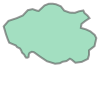

In [ ]:
gdf.geometry.values[0]

In [ ]:
gdf.geometry.bounds

,minx,miny,maxx,maxy
0,140.83477,42.590879,140.869703,42.613528


In [ ]:
target_size,target_bbox

((1635, 1512),
 BBox(((140.7582, 42.554), (140.9573, 42.6904)), crs=CRS('4326')))